### FashionMNIST cluster based on DBSCAN

-FashionMNIST is a dataset of grayscale images of 28x28 pixels representing 10 categories of clothing items.

-Though the dataset provides a label for each image, we can ignore all labels and use only images to do clustering tasks.

-This notebook uses DBSCAN to cluster the ten categories of FashionMNIST and compares the results.

### 运行说明：
### 该笔记需要python环境，环境中需确保有torch  matplotlib  torchvision  numpy  sklearn库

==============================================================================================================================================================

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import silhouette_score

In [2]:
class FashionMNISTClusterer:
    def __init__(self, eps=0.3, min_samples=10, n_components=50):
        """
        初始化聚类器
        
        参数:
        eps: DBSCAN的邻域半径
        min_samples: 构成核心点的最小样本数
        n_components: PCA降维的维度
        """
        self.eps = eps
        self.min_samples = min_samples
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.scaler = StandardScaler()
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
    def preprocess_data(self, X):
        """数据预处理：标准化和PCA降维"""
        X_scaled = self.scaler.fit_transform(X)
        X_pca = self.pca.fit_transform(X_scaled)
        return X_pca
        
    def fit_predict(self, X):
        """拟合数据并返回聚类标签"""
        X_processed = self.preprocess_data(X)
        labels = self.dbscan.fit_predict(X_processed)
        return labels
    
    def analyze_clusters(self, labels, X, true_labels):
        """分析聚类结果"""
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"估计的聚类数量: {n_clusters}")
        print(f"噪声点数量: {n_noise}")
        
        # 计算轮廓系数（排除噪声点）
        if len(set(labels)) > 1:  # 确保有多于一个簇
            mask = labels != -1
            if np.sum(mask) > 1:  # 确保有足够的非噪声点
                silhouette_avg = silhouette_score(X[mask], labels[mask])
                print(f"轮廓系数: {silhouette_avg:.3f}")
        
        return n_clusters, n_noise

In [9]:
def visualize_clusters(X, labels, true_labels, class_names):
    """可视化聚类结果"""
    plt.figure(figsize=(25, 20))
    
    # 为每个簇显示示例图像
    unique_labels = sorted(set(labels))
    for i, label in enumerate(unique_labels):
        # 获取该簇的所有图像索引
        mask = labels == label
        images_in_cluster = X[mask]
        true_labels_in_cluster = true_labels[mask]
        
        # 统计该簇中最常见的真实类别
        if len(true_labels_in_cluster) > 0:
            most_common = Counter(true_labels_in_cluster).most_common(1)[0]
            most_common_label = most_common[0]
            most_common_count = most_common[1]
            percentage = (most_common_count / len(true_labels_in_cluster)) * 100
            
            # 显示该簇的前5个样本
            for j in range(min(5, len(images_in_cluster))):
                plt.subplot(len(unique_labels), 5, i*5 + j + 1)
                plt.imshow(images_in_cluster[j].reshape(28, 28), cmap='gray')
                if j == 0:
                    cluster_name = "Noise" if label == -1 else f"Cluster {label}"
                    plt.title(f'{cluster_name}\n{class_names[most_common_label]}\n{percentage:.1f}%')
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_cluster_composition(labels, true_labels, class_names):
    """分析每个簇的组成"""
    unique_labels = sorted(set(labels))
    
    print("\n簇的组成分析:")
    print("-" * 50)
    
    for cluster_label in unique_labels:
        print(f"\n{'噪声点' if cluster_label == -1 else f'簇 {cluster_label}'} 的组成:")
        mask = labels == cluster_label
        cluster_true_labels = true_labels[mask]
        
        if len(cluster_true_labels) > 0:
            # 统计前三个最常见的类别
            common_labels = Counter(cluster_true_labels).most_common(3)
            total = len(cluster_true_labels)
            
            for label, count in common_labels:
                percentage = (count / total) * 100
                print(f"{class_names[label]}: {percentage:.1f}% ({count}/{total})")

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./fmnist_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))

images, labels = next(iter(train_loader))
X = images.numpy().reshape(len(images), -1)
y = labels.numpy()

In [5]:
# 类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# 创建并训练模型
clusterer = FashionMNISTClusterer(eps=5, min_samples=20, n_components=50)
cluster_labels = clusterer.fit_predict(X)

估计的聚类数量: 11
噪声点数量: 50411
轮廓系数: 0.057


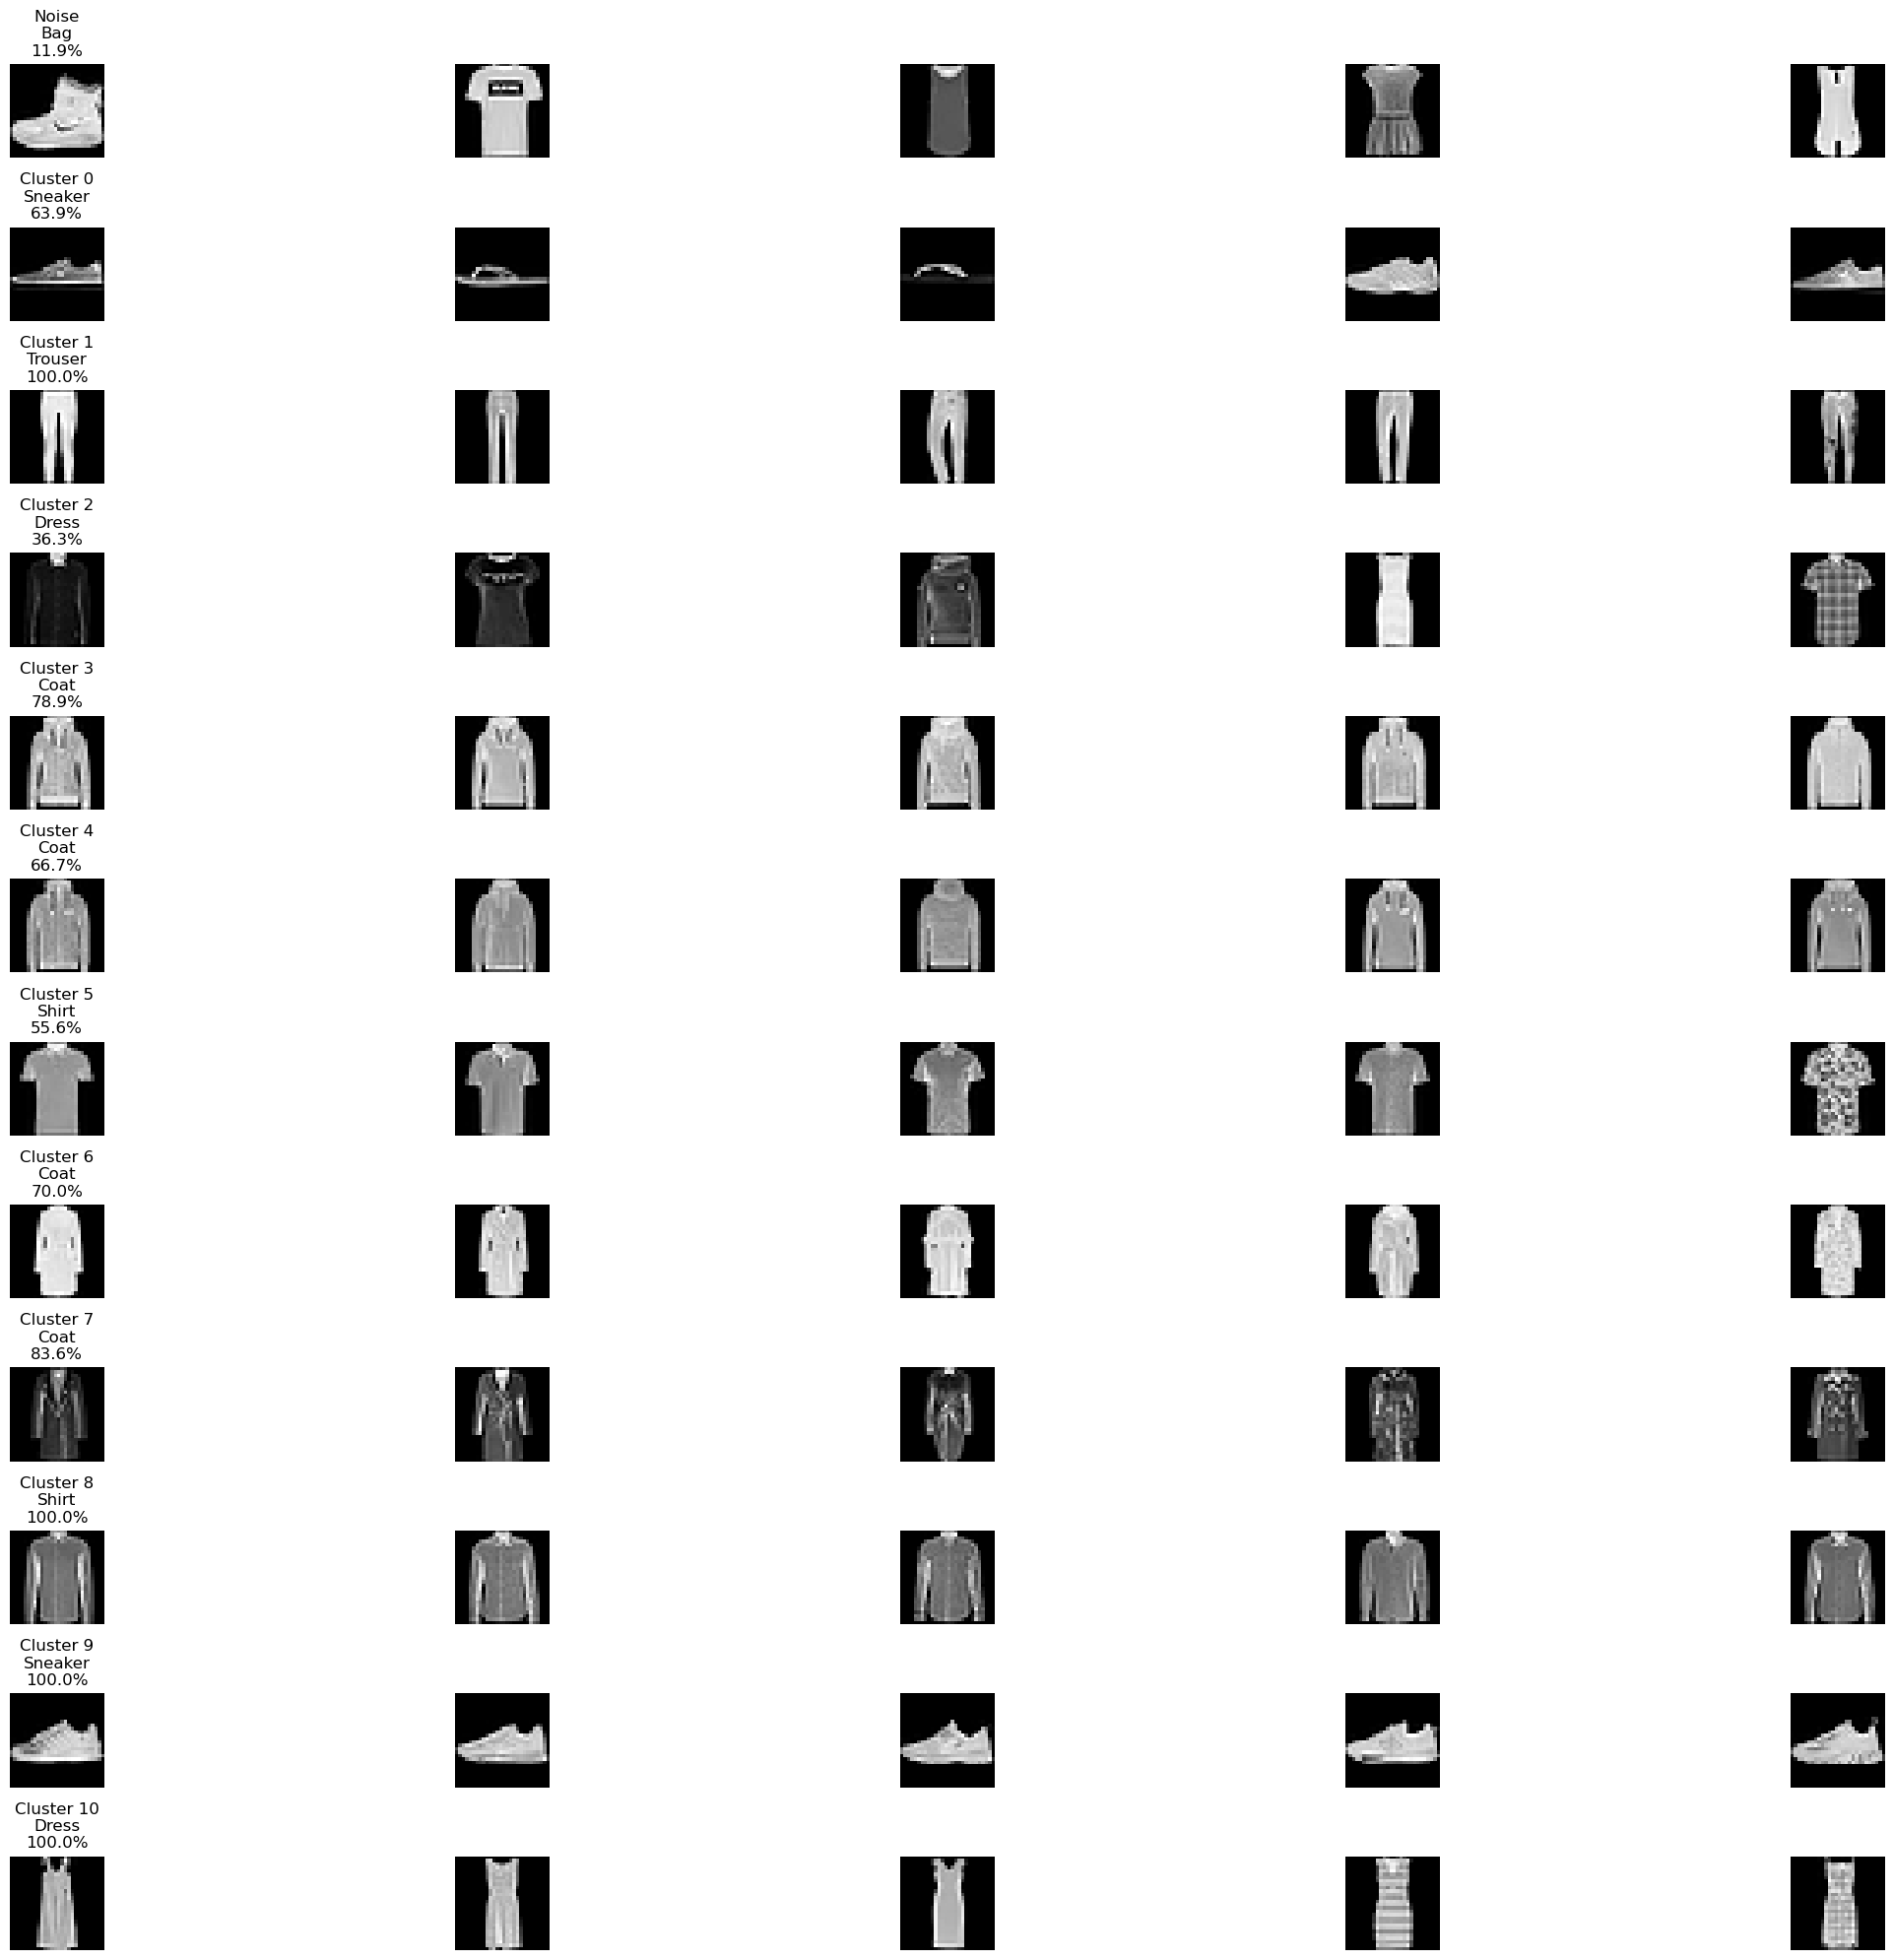


簇的组成分析:
--------------------------------------------------

噪声点 的组成:
Bag: 11.9% (6000/50411)
Ankle boot: 11.9% (5998/50411)
Coat: 11.5% (5775/50411)

簇 0 的组成:
Sneaker: 63.9% (1940/3037)
Sandal: 36.1% (1095/3037)
Ankle boot: 0.1% (2/3037)

簇 1 的组成:
Trouser: 100.0% (3975/3976)
Dress: 0.0% (1/3976)

簇 2 的组成:
Dress: 36.3% (849/2340)
Shirt: 31.5% (737/2340)
T-shirt/top: 12.7% (298/2340)

簇 3 的组成:
Coat: 78.9% (30/38)
Pullover: 21.1% (8/38)

簇 4 的组成:
Coat: 66.7% (12/18)
Pullover: 33.3% (6/18)

簇 5 的组成:
Shirt: 55.6% (10/18)
T-shirt/top: 44.4% (8/18)

簇 6 的组成:
Coat: 70.0% (14/20)
Dress: 30.0% (6/20)

簇 7 的组成:
Coat: 83.6% (46/55)
Dress: 7.3% (4/55)
Pullover: 5.5% (3/55)

簇 8 的组成:
Shirt: 100.0% (16/16)

簇 9 的组成:
Sneaker: 100.0% (37/37)

簇 10 的组成:
Dress: 100.0% (34/34)


d:\Anaconda\envs\hoshino\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\hoshino\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\hoshino\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\hoshino\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37322 (\N{CJK UNIFIED IDEOGRAPH-91CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\envs\hoshino\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_

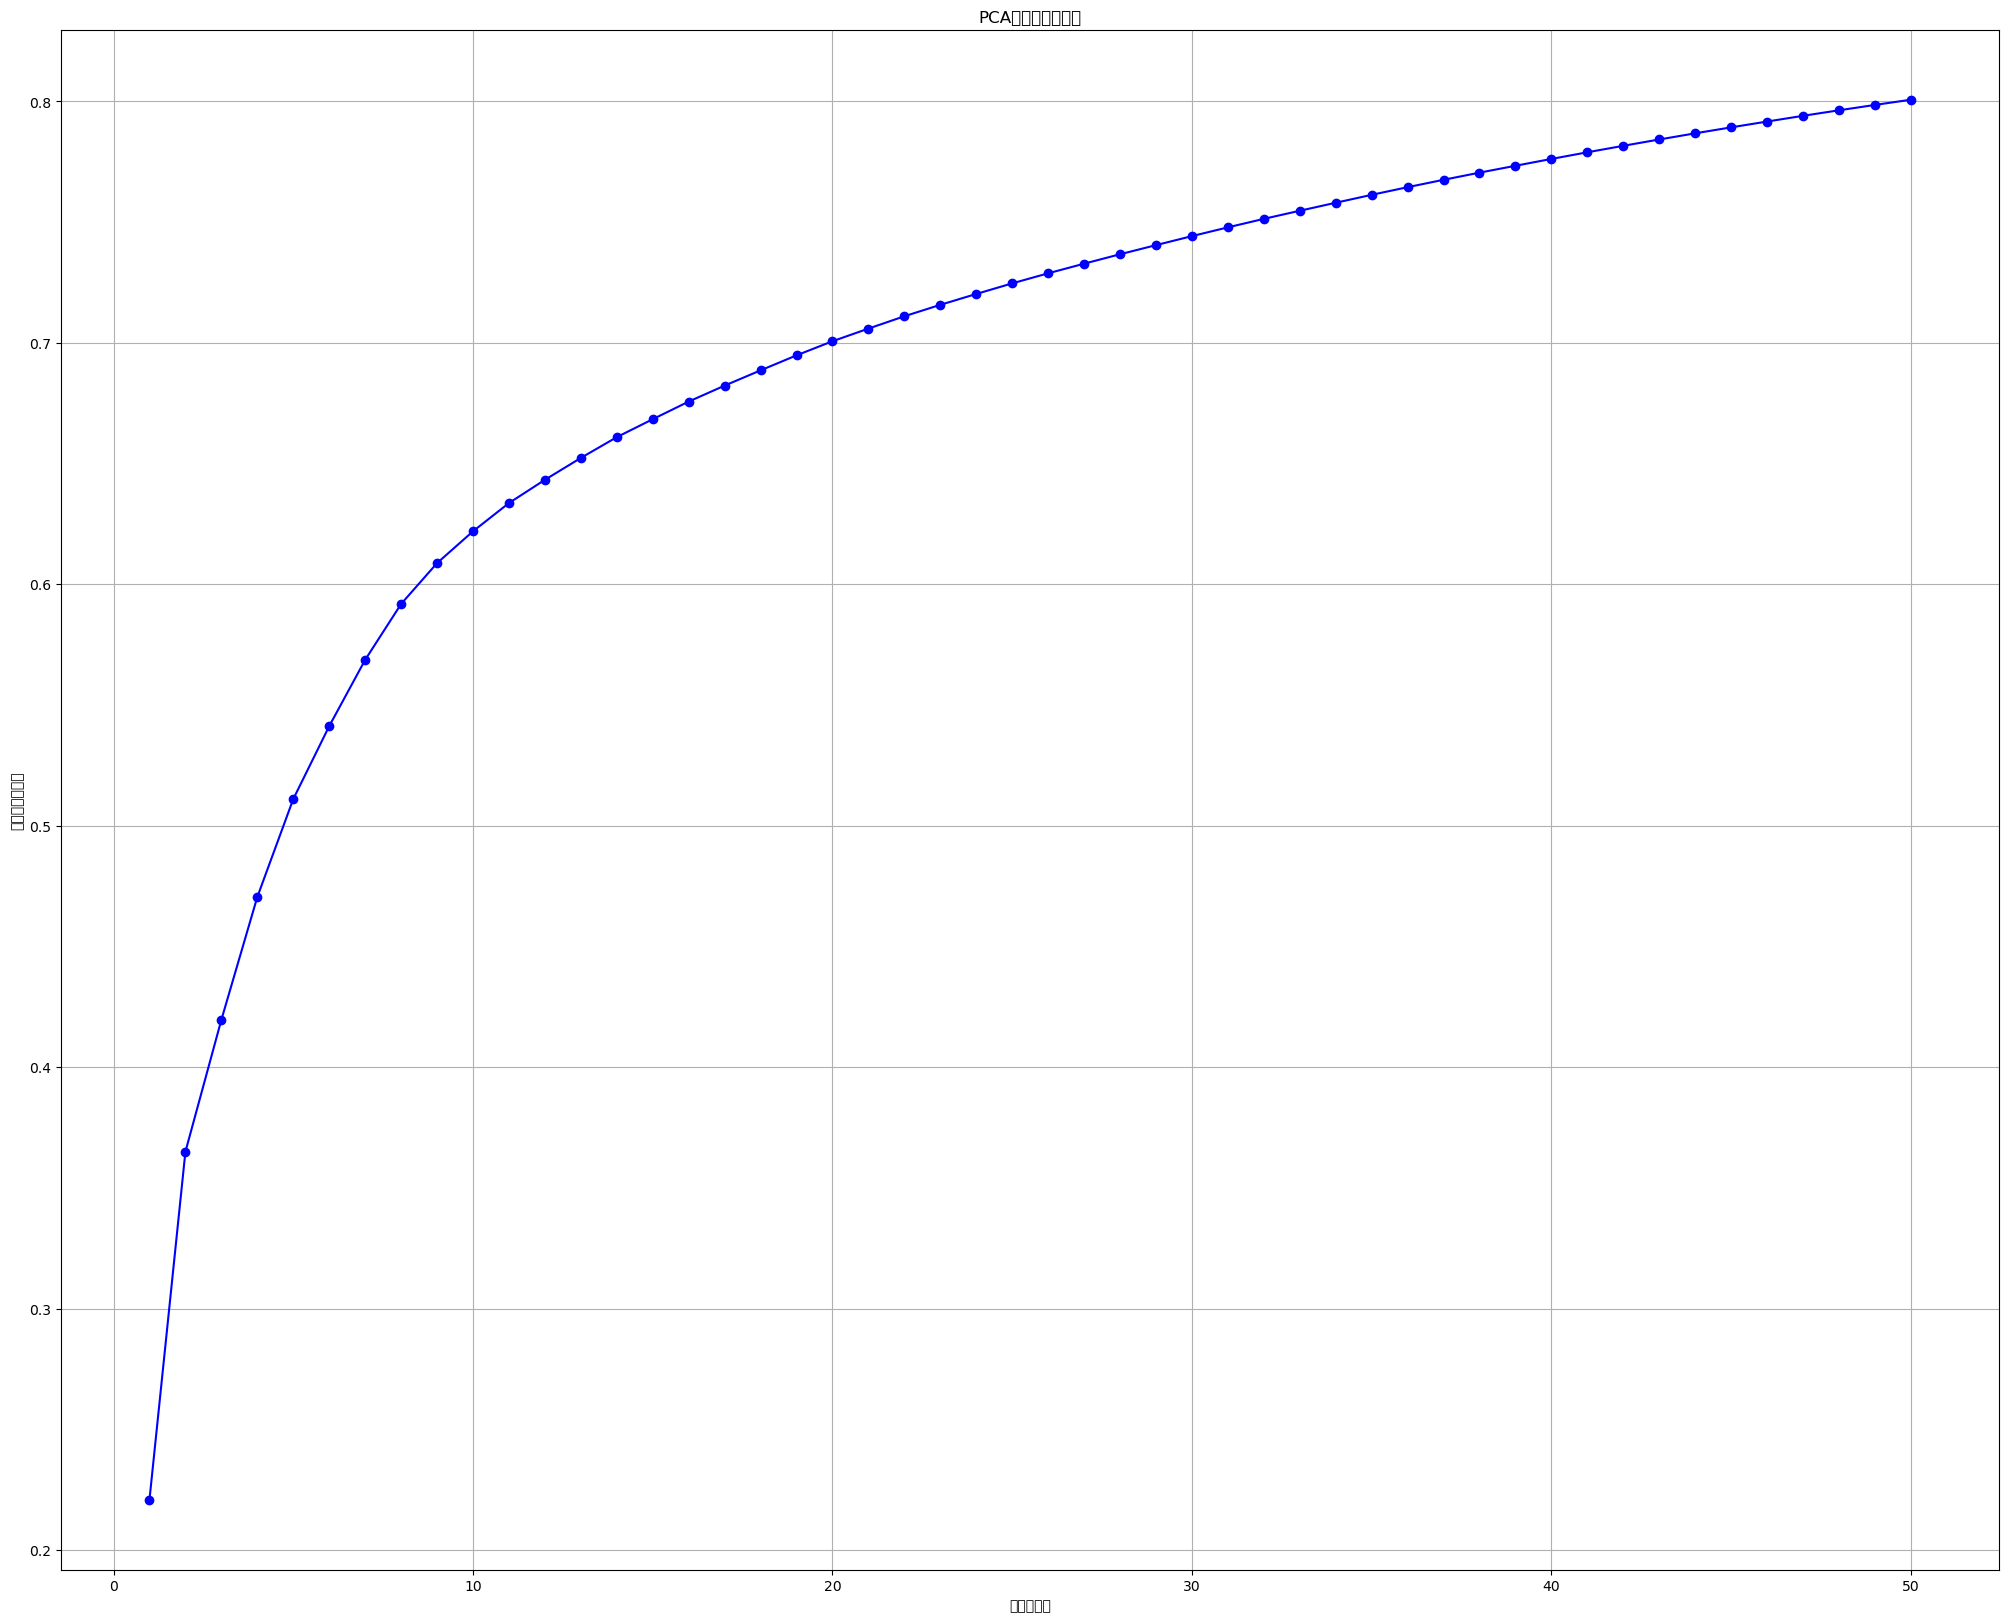

In [10]:
# 分析结果
n_clusters, n_noise = clusterer.analyze_clusters(cluster_labels, X, y)

# 可视化结果
visualize_clusters(X, cluster_labels, y, class_names)

# 分析簇的组成
analyze_cluster_composition(cluster_labels, y, class_names)

# 显示PCA解释方差比
explained_variance_ratio = clusterer.pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(25, 20))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('主成分数量')
plt.ylabel('累积解释方差比')
plt.title('PCA累积解释方差比')
plt.grid(True)
plt.show()
